
## Before your start:

   - Read the README.md file
   - Comment as much as you can and use the resources in the README.md file
   - Happy learning!



h=5
w=2
c=3
y = np.arange(h*w*c).reshape(h,w,c)
print(y)
y[:,:,1]

# Image Segmentation

**Image Segmentation** is an image analysis task in which we classify each pixel in the image into a class. This is similar to what us humans do all the time by default. 

What’s the first thing you do when you’re attempting to cross the road?

We typically look left and right, take stock of the vehicles on the road, and make our decision. Our brain is able to analyze, in a matter of milliseconds, what kind of vehicle (car, bus, truck, auto, etc.) is coming towards us. Whenever we are looking at something, then we try to “segment” what portion of the image belongs to which class/label/category.

![test](images/test.jpeg)

## So how does image segmentation work?

We can divide or partition the image into various parts called segments. It’s not a great idea to process the entire image at the same time as there will be regions in the image which do not contain any information. By dividing the image into segments, we can make use of the important segments for processing the image. That, in a nutshell, is how image segmentation works.

An image is a collection or set of different pixels. We group together the pixels that have similar attributes using image segmentation. 

**Sooner or later all things are numbers, including images.**

In [1]:
# Install torch & torchvision, it might take some time

#!pip3 install torch
#!pip3 install torchvision
#!pip3 install pillow

In [2]:
# Import your libraries

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal
from imageProcessing import resizeImg, generateMask
import torch
from torchvision import models
import torchvision.transforms as tt
import datetime

## Challenge 1 - Load a picture & let the magic begin!


In order to be able to segment an image, what **we first need is an image**. So, first thing you should do is loading one of yourself. Use [`Image.open`](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html) for this purpose and call `img` to this variable. (In case you don't want to use your own image you can use one located at `images/bird.png`.

Using this function you will be using Pillow, the most popular and de facto standard library in Python for loading and working with image data. However, if you'd like to see how gorgeous you look on that picture, try using [`plt.show`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.show.html).

In [3]:
!ls images
# Some of the images on the input folder cant get masked correctly,
# Like the closeup of `face.jpeg`, or `buildingtrees.jpeg` which come out with an empty layer
# Or the `habboclass.png` which return this error when masked: 
#'RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0'

bird.png	    carplane.jpeg   face.jpeg		plazamayor.jpeg
blured_bird.JPG     carrace.jpeg    futuristiccar.jpeg	puertadelsol.jpg
boat.jpeg	    cartilt.jpeg    habboclass.png	rooftop.jpeg
building.jpeg	    carwarlus.jpeg  ironhack.png	satellitedish.jpeg
building.png	    drawing.jpeg    ISS.jpg		test.jpeg
buildingtrees.jpeg  epic.png	    perritorgb.png	training.jpeg


(2048, 2048)


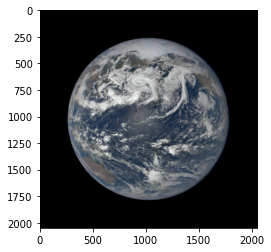

In [4]:
# Your code here
img = Image.open('images/epic.png')
print(img.size)
plt.imshow(img)

In [5]:
# Pepare to save the output
def exportOutput(ndarray, out_path):
    out_img = Image.fromarray(ndarray)
    out_img.save(out_path)
    print(f'Image saved at: {out_path}')
    
timestamp = datetime.datetime.today().strftime('%Y%m%d%H%M%S')    

Sometimes it is desirable to thumbnail all images to have the same width or height. In this case, the width, will be reduced to 256, using `resizeImg`, and the height will be scaled in order to retain the aspect ratio of the image.

*Hint: use `img.size` as much as you need until you get a size of (384, 256)*.

In [6]:
#dimension=(256,384)
#dimension=(384, 256)
def resizeImgTo(img, max_width):
    thumb = img
    dimension = (int(thumb.size[1]), int(thumb.size[0]))
    while int(thumb.size[1]) > max_width:    ## ♠ OPTIMIZATION :  Allow configuration of max width OR heightÇ
        print(thumb.size, 'INPUT')
        dimension = (int(thumb.size[1]*0.60), int(thumb.size[0]*0.60))
        thumb = resizeImg(thumb, dimension=dimension)
    print(thumb.size, 'OUTPUT')
    return thumb, dimension
#thumb = resizeImg(img, dimension=dimension)
thumb, dimension = resizeImgTo(img, 500)

(2048, 2048) INPUT
(1228, 1228) INPUT
(736, 736) INPUT
(441, 441) OUTPUT


But, don't worry! This time won't be that difficult, you get some code to make your life easier.
Here the function `generateMask`, as you may imagine, will generate a [`mask`](http://www.xinapse.com/Manual/masking.html) for the picture you loaded. One for the background of the picture, one for the foreground. 

# Making a mask with a Forward Convolutional Network
Inputs require an image and a network. Normalizes by using the `mean` and the `std`, and `tt.Compose` `torchvision.transforms`. Outputs a decoded segmap


### This PIL image will be transformed into a tensor which is compatible with the ResNEt 101 we just configured

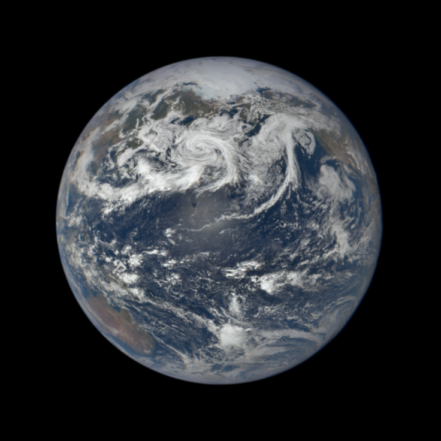

In [7]:
thumb  # ♠ OPTIMIZATION: PIL Image thumbnail, I used to be using the full size image
       #  and that was giving me trouble, capping my RAM and killing the jupyter kernel.

#### DECODE SEGMAP

Takes in an `image` and an `nc` as inputs.

Returns a `rgb` = `np.stack([r, g, b], axis=2)`

In [8]:
mask = generateMask(thumb)
background_mask = np.all(mask == [0, 0, 0], axis=-1)  # Para que sirve esto? No entiendo aun la logica aqui
foreground_mask = np.any(mask != [0, 0, 0], axis=-1)
foreground_mask.shape

(441, 441)

### Checking out the resulting masks

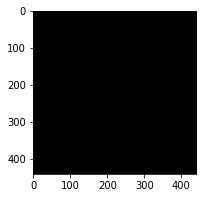

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(foreground_mask, cmap='gray')

### Now convert the thumbnail image into a np.array

In [10]:
thumb_arr = np.array(thumb)
print(thumb_arr.shape)             #3 channel image 

(441, 441, 3)


### And also apply the mask twice to the picture
     - once to the `foreground`,  
     - once to the `background`.

In [11]:
def usemask(numpy_image_array, mask_array):
    try:
        r=numpy_image_array[...,0] * mask_array
        g=numpy_image_array[...,1] * mask_array
        b=numpy_image_array[...,2] * mask_array
        return np.stack((r,g,b), axis=-1)
    except:
        raise ValueError('This function takes in an numpy array image with 3 color channels (RGB) ')
                         
rgb_fore = usemask(thumb_arr, foreground_mask)
rgb_back = usemask(thumb_arr, background_mask)                                 

     # After doing this, you may want to check how those are looking. 

### All possible combinations have been stored in the 3rd dimension of the arrays `rgb_fore` and `rgb_back`

In [12]:
dims = (int(thumb.size[1]), int(thumb.size[0])*2)
placeholder=np.zeros(dims)
placeholder.shape       # A Placeholder

(441, 882)

Image saved at: OUTPUT/masks-and-channels-20200427084621.png


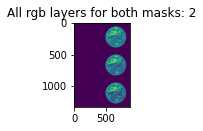

In [13]:
first_run = True
for l in range(3):
    channel_array = np.concatenate((rgb_fore[:,:,l],
                               rgb_back[:,:,l]), axis=-1)   
    if first_run: 
        groupped = channel_array
        first_run = False  
    else:
        groupped = np.concatenate((channel_array, groupped), axis=0)
plt.figure(figsize=(1,2))
plt.title(f'All rgb layers for both masks: {l}')
plt.imshow(groupped) 
exportOutput(groupped, f'OUTPUT/masks-and-channels-{timestamp}.png')
#groupped

(441, 882) (441, 882)
(441, 882) (441, 882)
(441, 882) (441, 882)


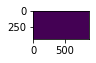

In [14]:
first_run = True
for l in range(3):
    if first_run:
        groupped = placeholder
        switch = False
    else:
        groupped = np.concatenate((channel_path, groupped), axis=0)
    channel_path = np.concatenate((rgb_fore[:,:,l],
                               rgb_back[:,:,l]), axis=-1)
    print(channel_path.shape, groupped.shape)

plt.figure(figsize=(1,2))
plt.imshow(groupped) 
#exportOutput(groupped, 'OUTPUT/channel.png')

### Make a couple of copies of the image instead of assigning the same value to different variables. 

In [15]:
# No entendi realmente que debia hacer con este enunciado

## Challenge 2 - Two 2-dimensional arrays, one channel

Convolution involving one-dimensional signals is referred to as 1D convolution or just convolution. Otherwise, if the convolution is performed between two signals spanning along two mutually perpendicular dimensions (i.e., if signals are two-dimensional in nature), then it will be referred to as [`2D convolution`](http://www.songho.ca/dsp/convolution/convolution2d_example.html). 

This kind of operation is extensively used in the field of digital image processing, such as smoothing, sharpening, and edge detection of images. Wherein the 2D matrix representing the image will be convolved with a comparatively smaller matrix called 2D kernel. 

[*What do you mean by one channel?*](https://brohrer.github.io/convert_rgb_to_grayscale.html)

Color images are represented as three-dimensional Numpy arrays - a collection of three two-dimensional arrays, one each for red, green, and blue channels. Each one, like grayscale arrays, has one value per pixel and their ranges are identical. 

An intuitive way to convert a color image 3D array to a grayscale 2D array is, for each pixel, take the average of the red, green, and blue pixel values to get the grayscale value. This combines the lightness or luminance contributed by each color band into a reasonable gray approximation. 

<img src="images/perritorgb.png" width="200">





#### First let's begin with black and white (only one channel)

Transform `foreground` and `background`, now they are arrays, to an image and convert them in gray scale. Name them `fore_bnw` and `back_bnw` respectively.

*Hint: use `.fromarray` and then `.convert`*.

#### Be careful when using the `Image.fromarray(np.uint8(data))`, the input must be uint8 to be decoded correctly

In [16]:
rgb_fore_img = Image.fromarray(rgb_fore)     # 3 channel np array to PIL.Image
rgb_back_img = Image.fromarray(rgb_back)
fore_bnw = rgb_fore_img.convert(mode='L')    # turn the RGB PIL.Image to Grayscale
back_bnw = rgb_back_img.convert(mode='L') 

Show `fore_bnw` and `back_bnw` in order to check that they are in a gray scale.

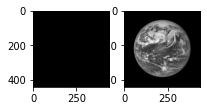

In [17]:
f,a = plt.subplots(1,2, figsize=(3,4))
a[0].imshow(fore_bnw, cmap='gray')
a[1].imshow(back_bnw, cmap='gray')

Now transform `back_bnw` into an array and name it `back_np`.

In [18]:
back_np = np.array(back_bnw)
fore_np = np.array(fore_bnw)

And create a 2d matrix with random values of size 20x20 uniformly distributed and name it `kernel`.

In [19]:
def rand_kernel(x,y):                # ♠ - Here i make a random kernel function for future use
    kernel = np.zeros((x,y))
    for r in range(x):
        for c in range(y):
            kernel[r,c] += np.random.uniform()
    print(f'kernel generated with dimensions: {x},{y}')
    return kernel 
kernel = rand_kernel(20,20)
kernel.mean(), kernel.size, kernel.shape

kernel generated with dimensions: 20,20


(0.4915130427357168, 400, (20, 20))

Now you must use `signal.convolve2d` from scipy and pass the array image (`back_np`) and the kernel as parameters. [Check the docs for `convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) and assign it to a variable called `conv`.

*Hint: use mode='same' in order to get an array with the same size as the input one.*

In [20]:
convolute = scipy.signal.convolve2d
conv = convolute(back_np, kernel, mode='same')
print(type(conv), conv.shape, conv.min(), conv.max(), )

<class 'numpy.ndarray'> (441, 441) 0.0 40755.7368593089


Now you must operate with `conv` in order to have their values between 0 and 255.

In [21]:

norm =  (conv /conv.max())*255       #Normalizing the 2d array
norm.min(), norm.max(), norm.mean()

(0.0, 255.0, 57.68139377886452)

Apply `.absolute` from numpy to the new value of `conv` and assign it to `back_blur`, and if you show this `back_blur` you will notice that the blur effect has been apply to the background.

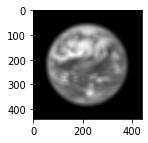

In [22]:
back_blur = np.abs(norm)
plt.figure(figsize=(2,2))
plt.imshow(back_blur, cmap='gray')

Finally, create a new variable called `final` which have `back_blur` and `fore_bnw` arrays using the `.add` function.

Make sure the type of the output is `np.uint8`, else use the `.astype` function. Show `final`.

In [23]:
final = np.add(back_blur, fore_bnw)

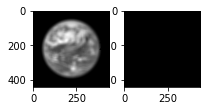

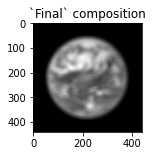

In [24]:
f,a = plt.subplots(1,2, figsize=(3,3))
a[0].imshow(back_blur, cmap='gray')
a[1].imshow(fore_bnw, cmap='gray')
plt.figure(figsize=(5,2))
plt.title('`Final` composition')
plt.imshow(final, cmap='gray')

## Challenge 3 -  Once wasn't enough, do it three times

**aquí es donde la matan**
-Marc Pomar

Define a `def blur(img): ...` function which blurs an image having RGB channels. To do this:
1. Using numpy generate a 2d matrix with random values of size 20x20 uniformly distributed. We call this the `kernel`.  
2. Use `signal.convolve2d` from scipy and pass the image and the kernel as parameters.[Check the docs for `convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)
3. Check the output values and ensure data is in range 0-255. *Hint: Divide the output array by max value.*

Make sure the type of the output is `np.uint8`.

In [25]:
# Your code here
def blur(img, dimension=(256,384)):
    kernel = rand_kernel(10,10)                        # Setup the kernel
    thumb = resizeImg(img, dimension=dimension)        # Resize the IMG  - ♠ OPTIMIZATION: Figure out how to resize correctly
    thumb_arr = np.array(thumb)                        # Turn PIL Image to np array  
    
    # A Placeholder for the color dimensions
    rgbArray = np.zeros((*dimension, 3), 'uint8')      # Set dimensions and data type
    
    # Do a convolution on every layer
    for channel in range(3):
            current_layer = scipy.signal.convolve2d(np.array(
                                                    thumb_arr[:,:,channel]),
                                                    kernel,
                                                    mode='same')
            rgbArray[...,channel] = np.uint8(
                                        (current_layer/current_layer.max()) *255)
    print(' ~ image has been blurred')
    return rgbArray

Once you have demonstrated you are a great coder defining the `blur` function. It's time for you to check if it works, bluring the background of the `background` image.

In [26]:
blurred_background = blur(rgb_back_img, dimension=dimension)
blurred_background2 = np.abs(blurred_background)

kernel generated with dimensions: 10,10
 ~ image has been blurred


Apply the `foreground_mask` again. 

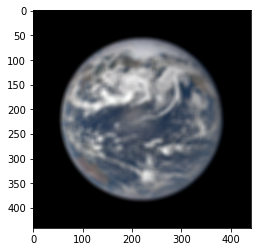

In [27]:
plt.imshow(blurred_background2)

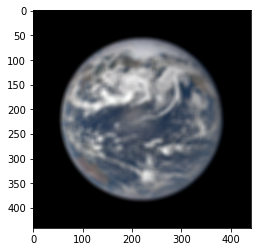

In [28]:
background_blur_and_masked = usemask(blurred_background2, ~foreground_mask)
plt.imshow(background_blur_and_masked)

Sum the blured background and the original foreground using [`np.add`](https://numpy.org/doc/1.18/reference/generated/numpy.add.html).

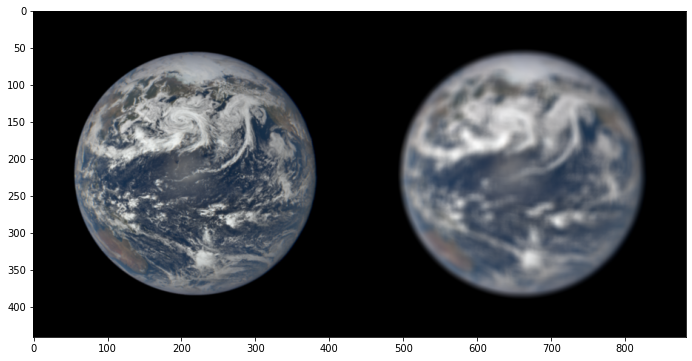

In [29]:
output = np.add(background_blur_and_masked, rgb_fore)
joint_compare = np.concatenate((thumb, output), axis=1)
plt.figure(figsize=(15,6))
plt.imshow(joint_compare)

# Madre mia... esto ha tomado mucho mas tiempo del que esperaba, pero he aprendido un monton

Finally, once you've got something like the picture below, please, export that **Image**. Make sure you add this result and all of those you generate to the Pull Request.

<img src="images/bird.png" width="100">
<img src="images/blured_bird.JPG" width="100">

In [30]:
# Save stand-alone image
exportOutput(output, f"OUTPUT/generated-{timestamp}.png")
exportOutput(joint_compare,f"OUTPUT/compared-{timestamp}.png")

Image saved at: OUTPUT/generated-20200427084621.png
Image saved at: OUTPUT/compared-20200427084621.png


## Enjoy your weekend!